## これは何？

論文
https://www.overleaf.com/project/5e8f7b5f2978e30001bb71b0
のシミュレーションです

In [ ]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy.spatial import distance #cosine similarity
from scipy import stats
import copy

# model parameters
mu_x = 3
d = 1
sigma_x = 2
sigma_eps = sigma_x * np.sqrt(d)
#sigma_eta = 1 
lmd = 1 #lambda
run_full = False
save_img = True
def is_colab():
    try:
        from google.colab import files
        return True
    except:
        return False

np.random.seed(1)
if run_full or (not is_colab()): # Full run
    R = 2000
    N = 1000
else: #short run (for debug: Only on google colab)
    R = 10
    N = 300

# matplotlib params
Alpha = 0.2
Capsize = 10
COLOR_UCB = "tab:blue"
COLOR_CS_UCB = "navy"
COLOR_HYBRID = "tab:orange"
COLOR_CS_HYBRID = "#cc4c0b" 
COLOR_GREEDY = "tab:red"
COLOR_ROONEY = "tab:blue"
COLOR_ROONEY_SWITCH = "tab:green" 
COLOR_ROONEY_GREEDY = "tab:red"
# linestyle
linestyle_tuple = {
     'loosely dotted':        (0, (1, 10)),
     'dotted':                (0, (1, 1)),
     'densely dotted':        (0, (1, 1)),

     'loosely dashed':        (0, (5, 10)),
     'dashed':                (0, (5, 5)),
     'densely dashed':        (0, (5, 1)),

     'loosely dashdotted':    (0, (3, 10, 1, 10)),
     'dashdotted':            (0, (3, 5, 1, 5)),
     'densely dashdotted':    (0, (3, 1, 1, 1)),

     'dashdotdotted':         (0, (3, 5, 1, 5, 1, 5)),
     'loosely dashdotdotted': (0, (3, 10, 1, 10, 1, 10)),
     'densely dashdotdotted': (0, (3, 1, 1, 1, 1, 1))
     }
LINESTYLE_UCB = "solid"
LINESTYLE_CS_UCB = linestyle_tuple["densely dashed"]
LINESTYLE_HYBRID = "dashdot"
LINESTYLE_CS_HYBRID = "dashed"
LINESTYLE_GREEDY = linestyle_tuple["densely dotted"]
LINESTYLE_CS_GREEDY = "dotted"
LINESTYLE_ROONEY = "dashdot"
LINESTYLE_ROONEY_SWITCH = linestyle_tuple["densely dashdotted"]
LINESTYLE_ROONEY_GREEDY = linestyle_tuple["densely dotted"]

Figsize = (6,4)
#Fontsize = 18 
plt.rcParams["font.size"] = 14
plt.rcParams["axes.linewidth"] = 1
plt.rcParams["lines.linewidth"] = 2
plt.rcParams["figure.subplot.bottom"] = 0.14

class Simulation:
    def __init__(self, Kg, N0, N=N, theta_pars = None, sigma_eta = 1, policy = "greedy", count_ws_regret = False, n_switch = -1):
        #print(f"N={N}")
        self.Kg = Kg
        self.N0 = N0
        self.N = N
        self.Ng = len(self.Kg) # Num of groups.
        self.K = np.sum(self.Kg)
        self.initial_order = np.random.permutation(range(self.K)) #initial sample order (shuffled)
        if theta_pars == None:
            self.thetas = [1 * np.ones(d) for g in range(self.Ng)] # theta = (1,1,..) 
        else:
            self.thetas = [theta_pars[g] * np.ones(d) for g in range(self.Ng)]
        #print(f"thetas = {self.thetas}")
        G_tmp = []
        #print(f"self.Kg = {self.Kg}")
        for g,ng in enumerate(self.Kg):
            for i in range(ng):
                G_tmp.append(g)
        self.gs = np.array(G_tmp) #group attribution
        #print(f"g = {self.gs}")
        self.policy = policy
        self.count_ws_regret = count_ws_regret
        self.n_switch = n_switch
        self.Vs = [lmd * np.identity(d) for g in range(self.Ng)]
        self.xys = [np.zeros(d) for g in range(self.Ng)]
        self.regret = 0 #total regret
        self.strong_regret = 0 #Unconstrained regret in the paper
        self.draws = np.zeros(self.Ng) # num of draws of each group
        self.subsidy = 0 #total subsidy
        self.regret_seq = np.zeros(self.N)
        self.strong_regret_seq = np.zeros(self.N)
        self.subsidycs = 0 #total subsidy (cost-saving scheme)
        self.draws_seq = np.zeros((self.N, self.Ng))
        self.subsidy_seq = np.zeros(self.N)
        self.subsidycs_seq = np.zeros(self.N)
        self.sigma_eta = sigma_eta
        self.n = 0
    def draw_x(self, g): 
        return np.array([mu_x + sigma_x * np.random.normal() for f in range(d)])
    def get_htheta(self, g): # hat{theta} = Vg^-1 xy
        return np.linalg.solve(self.Vs[g], self.xys[g])
    def get_ttheta(self, x, g, htheta): # UCB index
        alpha = 1 /np.sqrt(d) #scale param
        delta = 0.1
        V = self.Vs[g]
        w,P = np.linalg.eig(V)
        s = np.sum(np.log(w)) - d * np.log(lmd) + 2 * np.log(1./delta)  
        width = sigma_eps * alpha * np.sqrt(s) #confidence diwth
        P_inv = np.linalg.inv(P) 
        D = P_inv @ V @ P
        #print(f'UCB V = {V}, P = {P}, P_inv = {P_inv}, D = {D}')
        xd = P_inv @ x
        normalized_xd = np.array([xd[f] / np.sqrt(D[f,f]) for f in range(d)]) 
        #print(f"normalized_xd = {normalized_xd}")
        my_norm = np.sqrt(np.inner(normalized_xd, D @ normalized_xd))
        xd_ex = normalized_xd * (width / my_norm)
        xd_ex_rec = P @ xd_ex 
        return xd_ex_rec + htheta
    def get_bestarm(self, xs): #best arm
        istar = np.argmax([self.get_q(x,i) for i,x in enumerate(xs)])
        return istar
    def select_arm(self, xs):
        if self.n == self.N0:
            for g in range(self.Ng):
                #print(f"n={self.n}, g={g}, htheta={self.get_htheta(g)}, draw[{g}]={self.draws[g]}")
                pass
        if self.n < self.N0: # initial samples
            vs_htheta = np.zeros(len(xs))
            vs_htheta_group = np.zeros(len(xs)) #not used
            iota = self.initial_order[ self.n % self.K ]
            g_iota = self.gs[iota] #group of iota
            for i,x in enumerate(xs):
                g = self.gs[i]
                htheta = self.get_htheta(g)
                vs_htheta[i] = np.inner(x, htheta)
                if g == g_iota:
                    vs_htheta_group[i] = np.inner(x, htheta)
                else:
                    vs_htheta_group[i] = - 10000000
            self.subsidycs_seq[self.n] = self.subsidycs
            if self.count_ws_regret:
                istar = np.argmax(vs_htheta) #best arm
                self.subsidycs += vs_htheta[istar] - vs_htheta[iota]
            self.subsidycs_seq[self.n] = self.subsidycs
            return iota
        elif self.policy == "greedy": #LF
            vs = np.zeros(len(xs))
            for i,x in enumerate(xs):
                g = self.gs[i]
                htheta = self.get_htheta(g)
                vs[i] = np.inner(x, htheta)
            self.subsidycs_seq[self.n] = self.subsidycs
            return np.argmax(vs)
        elif self.policy == "ucb" or self.policy == "improved_ucb": #imporoved ucb = hybrid in the paper
            vs = np.zeros(len(xs))
            vs_htheta = np.zeros(len(xs))
            for i,x in enumerate(xs):
                g = self.gs[i]
                htheta = self.get_htheta(g)
                ttheta = self.get_ttheta(x, g, htheta)
                vs_htheta[i] = np.inner(x, htheta)
                if self.policy == "ucb":
                    vs[i] = np.inner(x, ttheta)
                else: # iucb (hybrid)
                    Delta = np.inner(x, ttheta - htheta)
                    if Delta <= sigma_x * np.linalg.norm(htheta): 
                        vs[i] = np.inner(x, htheta) #no subsidize
                    else:
                        vs[i] = np.inner(x, ttheta) #subsidize
            istar = np.argmax(vs) # best arm
            self.subsidy += vs[istar] - vs_htheta[istar]
            self.subsidycs += np.max(vs_htheta) - vs_htheta[istar]
            self.subsidy_seq[self.n] = self.subsidy
            self.subsidycs_seq[self.n] = self.subsidycs
            return istar
        elif self.policy == "rooney": # and (self.n % 10) == 0:
            # first stage
            vs = np.zeros(len(xs))
            vs_true = np.zeros(len(xs))
            for i,x in enumerate(xs):
                g = self.gs[i]
                htheta = self.get_htheta(g)
                vs[i] = np.inner(x, htheta)
                vs_true[i] = np.inner(x, self.thetas[g])
#            print(f"vs = {vs}")
#            print(f"true vs = {vs_true}")
            i_gs = np.array([-1 for g in range(self.Ng)]) #finalist for each group
            for g in range(self.Ng):
                vs_filt = np.zeros(len(xs))
                for i,x in enumerate(xs):
                    if g == self.gs[i]:
                        vs_filt[i] = vs[i]
                    else:
                        vs_filt[i] = -10000000
                i_gs[g] = np.argmax(vs_filt)
#            print(f"finalists = {i_gs}")
            # second stage 
#            self.i_gs = i_gs
            self.etas = np.array([self.sigma_eta * np.random.normal() for i in xs]) #2nd stage information (additional signals)
            finalist_vs = np.array([vs[i] + self.etas[i] for i in i_gs])
            g = np.argmax(finalist_vs)
#            print(f"self.etas = {self.etas}")
#            print(f"finalist_vs = {finalist_vs}")
#            print(f"selected = {i_gs[g]}")
#            print(f"get_qs = {[self.get_q(x,i) for i,x in enumerate(xs)]}")
            return i_gs[g]
        elif self.policy in ["rooney", "rooney_greedy"]: #rooney-greedy = LF (2-stage)
            # first stage
            vs = np.zeros(len(xs))
            vs_true = np.zeros(len(xs))
            for i,x in enumerate(xs):
                g = self.gs[i]
                htheta = self.get_htheta(g)
                vs[i] = np.inner(x, htheta)
                vs_true[i] = np.inner(x, self.thetas[g])
            #print(f"vs = {vs}")
            #print(f"true vs = {vs_true}")
            i_gs = np.array([-1 for g in range(self.Ng)]) 
            vs_filt = copy.deepcopy(vs)
            for g in range(self.Ng):
                i_gs[g] = np.argmax(vs_filt)
                vs_filt[ i_gs[g] ] = -10000000
            self.etas = np.array([self.sigma_eta * np.random.normal() for i in xs]) #addiional signal eta
            finalist_vs = np.array([vs[i] + self.etas[i] for i in i_gs])
            finalist_vs_true = np.array([vs_true[i] + self.etas[i] for i in i_gs])
            g = np.argmax(finalist_vs)
#            true_g = np.argmax(finalist_vs_true)
#            if g != true_g:
#                print(f"g = {g}, true_best = {true_g}")
            return i_gs[g]
        else:
            print("Unknown policy");assert(False)
    def get_q(self, x, i):
        g = self.gs[i]
        theta_g = self.thetas[g]
        if not self.policy in ["rooney", "rooney_greedy"] or self.n < self.N0:
            return np.inner(x, theta_g)
        else:
            return np.inner(x, theta_g) + self.etas[i]
    def get_reward(self, x, i):
        eps = sigma_eps * np.random.normal()
        return self.get_q(x, i) + eps
    def calculate_rooney_best(self, xs): 
        # calc Rooney Regret
        qs_base = [np.inner(x, self.thetas[self.gs[i]]) for i,x in enumerate(xs)]
        i_gs = np.array([-1 for g in range(self.Ng)]) 
        for g in range(self.Ng):
            qs_filt = np.zeros(len(xs))
            for i,x in enumerate(xs):
                if g == self.gs[i]:
                    qs_filt[i] = qs_base[i]
                else:
                    qs_filt[i] = -10000000
            i_gs[g] = np.argmax(qs_filt)
        finalist_qs = np.array([qs_base[i] + self.etas[i] for i in i_gs])
        rooney_best_q = np.max(finalist_qs)
        # greedyでG人とったとき
        qs_filt = copy.deepcopy(qs_base)
        i_gs = np.array([-1 for g in range(self.Ng)])
        for g in range(self.Ng):
            i_gs[g] = np.argmax(qs_filt)
            qs_filt[ i_gs[g] ] = -10000000
        finalist_qs = np.array([qs_base[i] + self.etas[i] for i in i_gs])
        omni_best_q = np.max(finalist_qs)
#        if rooney_best_q != omni_best_q:
#            print("two regret did not match")
        return (rooney_best_q, omni_best_q) 
    def update_reward(self, xs, y, i, g):
        x = xs[i]
        xx = np.outer(x, x)
        xy = x*y
        self.Vs[g] += xx
        self.xys[g] += xy
        # regret更新
        if self.n >= self.N0 or self.count_ws_regret:
            if not self.policy in ["rooney", "rooney_greedy"]:
                istar = self.get_bestarm(xs)
                self.regret += self.get_q(xs[istar], istar) - self.get_q(xs[i], i)
#                print(f"istar = {istar} regret = {self.get_q(xs[istar], istar) - self.get_q(xs[i], i)}")
            else: #rooney
                rooney_best_q, omni_best_q = self.calculate_rooney_best(xs)
                #if self.policy == "rooney_greedy":
                #    print(omni_best_q - self.get_q(xs[i], i))
                self.regret += rooney_best_q - self.get_q(xs[i], i)
                self.strong_regret += omni_best_q - self.get_q(xs[i], i)
        self.draws[g] += 1
        self.regret_seq[self.n] = self.regret
        if self.policy in ["rooney", "rooney_greedy"]:
            self.strong_regret_seq[self.n] = self.strong_regret
        self.draws_seq[self.n] = self.draws
        self.n = self.n + 1
        self.eta = None
    def is_perpetunderest(self):
        #self.perpunderestimate = True
        for g in range(self.Ng):
            if self.draws[g] == self.draws_seq[self.N0, g]: 
                return True 
        return False
    def round(self):
        # draw context
        xs = [self.draw_x(self.gs[i]) for i in range(self.K)]
        # select arm
        iota = self.select_arm(xs)
        # observe reward
        x = xs[iota]
        y = self.get_reward(x, iota)
        # update model parameters
        self.update_reward(xs, y, iota, self.gs[iota])
    def run(self):
        for n in range(self.N):
            if self.n_switch == self.n and self.policy == "rooney": #if n_switch is set then turns to greedy (LF) at some timestep
                self.policy = "rooney_greedy" 
            self.round()

def my_show():
    try:
        from google.colab import files
        plt.show()
    except:
        pass

def colab_save(filename):
    try:
        from google.colab import files
        files.download(filename)  
    except:
        pass

# parallel computation
def run_sim(sim):
    sim.run()
    return sim
from joblib import Parallel, delayed

sigma_eta = 1.2, k_list = (10, 2)
pu_count, pu_count_switch, pu_count_greedy = 0, 2, 1


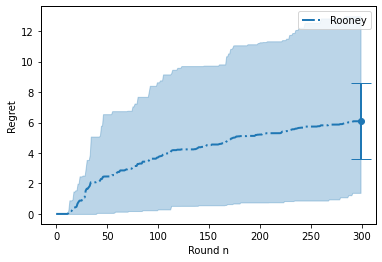

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<Figure size 432x288 with 0 Axes>

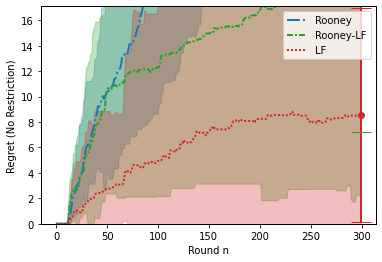

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<Figure size 432x288 with 0 Axes>

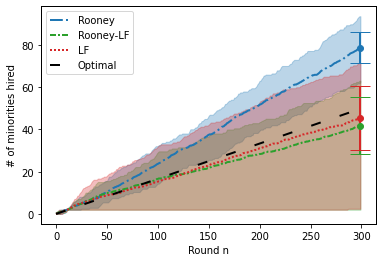

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<Figure size 432x288 with 0 Axes>

In [ ]:
# 実験（2stage Rooney versus LF)
def experiment7():
    #sigma_etas = np.sqrt(d) * np.array([0, 0.2, 0.4, 0.6, 0.8]) 
    sigma_eta = np.sqrt(d) * 1.2
    pu_count, pu_count_switch, pu_count_greedy = 0, 0, 0 
    all_regret = np.zeros((R, N))
    all_strong_regret = np.zeros((R, N))
    all_regret_switch = np.zeros((R, N))
    all_strong_regret_switch = np.zeros((R, N))
    all_regret_greedy = np.zeros((R, N))
    all_strong_regret_greedy = np.zeros((R, N))
    all_draw2 = np.zeros((R, N))
    all_draw2_switch = np.zeros((R, N))
    all_draw2_greedy = np.zeros((R, N))
    k_list = (10, 2)
    sims = [Simulation(Kg = k_list, N0 = np.sum(k_list)*1, sigma_eta = sigma_eta, policy = "rooney") for r in range(R)] 
    sims = Parallel(n_jobs=-1)( [delayed(run_sim)(sims[r]) for r in range(R)] ) #parallel computation
    sims_switch = [Simulation(Kg = k_list, N0 = np.sum(k_list)*1, sigma_eta = sigma_eta, policy = "rooney", n_switch = 50) for r in range(R)] 
    sims_switch = Parallel(n_jobs=-1)( [delayed(run_sim)(sims_switch[r]) for r in range(R)] ) #parallel computation
    sims_greedy = [Simulation(Kg = k_list, N0 = np.sum(k_list)*1, sigma_eta = sigma_eta, policy = "rooney_greedy") for r in range(R)]
    sims_greedy = Parallel(n_jobs=-1)( [delayed(run_sim)(sims_greedy[r]) for r in range(R)] ) #parallel computation
    print(f"sigma_eta = {sigma_eta}, k_list = {k_list}")
    for r in range(R):
        #print(f"r={r}")
        if sims[r].is_perpetunderest():
            pu_count += 1
        if sims_switch[r].is_perpetunderest():
            pu_count_switch += 1
        if sims_greedy[r].is_perpetunderest():
            pu_count_greedy += 1
        all_regret[r,:] = sims[r].regret_seq
        all_strong_regret[r,:] = sims[r].strong_regret_seq
        all_draw2[r,:] = sims[r].draws_seq[:,1]
        all_regret_switch[r,:] = sims_switch[r].regret_seq
        all_strong_regret_switch[r,:] = sims_switch[r].strong_regret_seq
        all_draw2_switch[r,:] = sims_switch[r].draws_seq[:,1]
        all_regret_greedy[r,:] = sims_greedy[r].regret_seq
        all_strong_regret_greedy[r,:] = sims_greedy[r].strong_regret_seq
        all_draw2_greedy[r,:] = sims_greedy[r].draws_seq[:,1]
    print(f"pu_count, pu_count_switch, pu_count_greedy = {pu_count}, {pu_count_switch}, {pu_count_greedy}")

    fig = plt.figure(figsize=Figsize)
    #plt.plot(range(N), avg_draw2, label = "LF")
    #plt.bar(range(len(sigma_etas)), avg_regret, tick_label=labels, align="center")
    avg_regret = np.mean(all_regret, axis=0)
    std_regret = np.std(all_regret, axis=0)
    avg_regret_switch = np.mean(all_regret_switch, axis=0)
    std_regret_switch = np.std(all_regret_switch, axis=0)
    avg_regret_greedy = np.mean(all_regret_greedy, axis=0)
    std_regret_greedy = np.std(all_regret_greedy, axis=0)
    avg_strong_regret = np.mean(all_strong_regret, axis=0)
    std_strong_regret = np.std(all_strong_regret, axis=0)
    avg_strong_regret_switch = np.mean(all_strong_regret_switch, axis=0)
    std_strong_regret_switch = np.std(all_strong_regret_switch, axis=0)
    avg_strong_regret_greedy = np.mean(all_strong_regret_greedy, axis=0)
    std_strong_regret_greedy = np.std(all_strong_regret_greedy, axis=0)
    #plt.plot(range(N), avg_regret, label = "sigma_eta = "+str(sigma_eta))

    lower_quantile_regret = np.quantile(all_regret, 0.05, axis=0)
    upper_quantile_regret = np.quantile(all_regret, 0.95, axis=0)
    plt.plot(range(N), avg_regret, label = "Rooney", color = COLOR_ROONEY, linestyle = LINESTYLE_ROONEY) #
    plt.errorbar([N-1], avg_regret[-1], yerr=2*std_regret[-1]/np.sqrt(R), fmt='o', capsize = Capsize, color = COLOR_ROONEY) #2 sigma
    plt.fill_between(range(N), lower_quantile_regret, upper_quantile_regret, alpha=0.3, color = COLOR_ROONEY) 
    plt.ylabel("Regret")
#    plt.xlabel("sigma_eta")
    plt.xlabel("Round n")
    plt.legend()
    
    my_show()
    if save_img:
        fig.savefig('rooney_largeg2_regret.pdf', dpi=fig.dpi)
        colab_save('rooney_largeg2_regret.pdf')
    plt.clf()
    
    fig = plt.figure(figsize=Figsize)

    lower_quantile_strong_regret = np.quantile(all_strong_regret, 0.05, axis=0)
    upper_quantile_strong_regret = np.quantile(all_strong_regret, 0.95, axis=0)
    plt.plot(range(N), avg_strong_regret, label = "Rooney", color = COLOR_ROONEY, linestyle = LINESTYLE_ROONEY)
    plt.errorbar([N-1], avg_strong_regret[-1], yerr=2*std_strong_regret[-1]/np.sqrt(R), fmt='o', capsize = Capsize, color = COLOR_ROONEY) #2 sigma
    plt.fill_between(range(N), lower_quantile_strong_regret, upper_quantile_strong_regret, alpha=0.3, color = COLOR_ROONEY)

    lower_quantile_strong_regret_switch = np.quantile(all_strong_regret_switch, 0.05, axis=0)
    upper_quantile_strong_regret_switch = np.quantile(all_strong_regret_switch, 0.95, axis=0)
    plt.plot(range(N), avg_strong_regret_switch, label = "Rooney-LF", color = COLOR_ROONEY_SWITCH, linestyle = LINESTYLE_ROONEY_SWITCH)
    plt.errorbar([N-1], avg_strong_regret_switch[-1], yerr=2*std_strong_regret_switch[-1]/np.sqrt(R), fmt='o', capsize = Capsize, color = COLOR_ROONEY_SWITCH) #2 sigma
    plt.fill_between(range(N), lower_quantile_strong_regret_switch, upper_quantile_strong_regret_switch, alpha=0.3, color = COLOR_ROONEY_SWITCH)

    lower_quantile_strong_regret_greedy = np.quantile(all_strong_regret_greedy, 0.05, axis=0)
    upper_quantile_strong_regret_greedy = np.quantile(all_strong_regret_greedy, 0.95, axis=0)
    plt.plot(range(N), avg_strong_regret_greedy, label = "LF", color= COLOR_ROONEY_GREEDY, linestyle = LINESTYLE_ROONEY_GREEDY)
    plt.errorbar([N-1], avg_strong_regret_greedy[-1], yerr=2*std_strong_regret_greedy[-1]/np.sqrt(R), fmt='o', capsize = Capsize, color = COLOR_ROONEY_GREEDY) #2 sigma
    plt.fill_between(range(N), lower_quantile_strong_regret_greedy, upper_quantile_strong_regret_greedy, alpha=0.3, color = COLOR_ROONEY_GREEDY)

    plt.ylim((0,avg_strong_regret_greedy[-1]*2))
    plt.ylabel("Regret (No Restriction)")
#    plt.xlabel("sigma_eta")
    plt.xlabel("Round n")
    plt.legend()
    my_show()
    if save_img:
        fig.savefig('rooney_largeg2_strong_regret.pdf', dpi=fig.dpi)
        colab_save('rooney_largeg2_strong_regret.pdf')
    plt.clf()

    fig = plt.figure(figsize=Figsize)
    #plt.plot(range(N), avg_draw2, label = "LF")
    avg_draw2 = np.mean(all_draw2, axis=0)
    std_draw2 = np.std(all_draw2, axis=0)
    lower_quantile_draw2 = np.quantile(all_draw2, 0.05, axis=0)
    upper_quantile_draw2 = np.quantile(all_draw2, 0.95, axis=0)
    avg_draw2_switch = np.mean(all_draw2_switch, axis=0)
    std_draw2_switch = np.std(all_draw2_switch, axis=0)
    lower_quantile_draw2_switch = np.quantile(all_draw2_switch, 0.05, axis=0)
    upper_quantile_draw2_switch = np.quantile(all_draw2_switch, 0.95, axis=0)
    avg_draw2_greedy = np.mean(all_draw2_greedy, axis=0)
    std_draw2_greedy = np.std(all_draw2_greedy, axis=0)
    lower_quantile_draw2_greedy = np.quantile(all_draw2_greedy, 0.05, axis=0)
    upper_quantile_draw2_greedy = np.quantile(all_draw2_greedy, 0.95, axis=0)
    plt.plot(range(N), avg_draw2, label = "Rooney", color = COLOR_ROONEY, linestyle = LINESTYLE_ROONEY)
    plt.errorbar([N-1], avg_draw2[-1], yerr=2*std_draw2[-1]/np.sqrt(R), fmt='o', capsize = Capsize, color = COLOR_ROONEY) #2 sigma
    plt.fill_between(range(N), lower_quantile_draw2, upper_quantile_draw2, alpha=0.3, color = COLOR_ROONEY)
    plt.plot(range(N), avg_draw2_switch, label = "Rooney-LF", color = COLOR_ROONEY_SWITCH, linestyle = LINESTYLE_ROONEY_SWITCH)
    plt.errorbar([N-1], avg_draw2_switch[-1], yerr=2*std_draw2_switch[-1]/np.sqrt(R), fmt='o', capsize = Capsize, color = COLOR_ROONEY_SWITCH) #2 sigma
    plt.fill_between(range(N), lower_quantile_draw2_switch, upper_quantile_draw2_switch, alpha=0.3, color = COLOR_ROONEY_SWITCH)
    plt.plot(range(N), avg_draw2_greedy, label = "LF", color= COLOR_ROONEY_GREEDY, linestyle = LINESTYLE_ROONEY_GREEDY)
    plt.errorbar([N-1], avg_draw2_greedy[-1], yerr=2*std_draw2_greedy[-1]/np.sqrt(R), fmt='o', capsize = Capsize, color = COLOR_ROONEY_GREEDY) #2 sigma
    plt.fill_between(range(N), lower_quantile_draw2_greedy, upper_quantile_draw2_greedy, alpha=0.3, color = COLOR_ROONEY_GREEDY)
    plt.plot(range(N), [i*k_list[1]/np.sum(k_list) for i in range(N)], label = "Optimal", color = "black", linestyle=linestyle_tuple["loosely dashed"])
    plt.ylabel("# of minorities hired")
    plt.xlabel("Round n")
    plt.legend()
    my_show()
    if save_img:
        fig.savefig('rooney_largeg2_draw2.pdf', dpi=fig.dpi)
        colab_save('rooney_largeg2_draw2.pdf')
    plt.clf()

experiment7()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

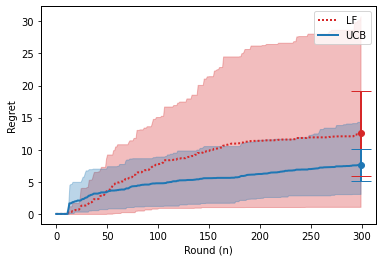

<Figure size 432x288 with 0 Axes>

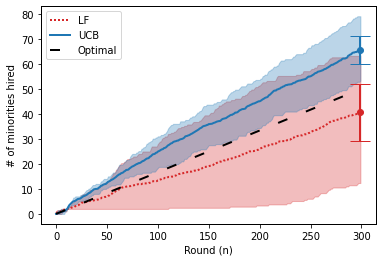

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<Figure size 432x288 with 0 Axes>

In [ ]:
# LF versus UCB
def experiment2():
    Kg = (10, 2)
    sims = [Simulation(Kg = Kg, N0 = np.sum(Kg)*1, policy = "greedy") for r in range(R)]
    sims_ucb = [Simulation(Kg = Kg, N0 = np.sum(Kg)*1, policy = "ucb") for r in range(R)]
    sims = Parallel(n_jobs=-1)( [delayed(run_sim)(sims[r]) for r in range(R)] ) #parallel computation
    sims_ucb = Parallel(n_jobs=-1)( [delayed(run_sim)(sims_ucb[r]) for r in range(R)] )
#    for r in range(R):
#        sims[r].run()
#        print(f"Greedy Run {r}: Perpetually underestimated {sims[r].is_perpetunderest()}")
#    for r in range(R):
#        sims_ucb[r].run()
#        print(f"UCB Run {r}: Perpetually underestimated {sims_ucb[r].is_perpetunderest()}")
    all_regret = np.zeros( (R, N) )
    all_regret_ucb = np.zeros( (R, N) )
    all_draw2 = np.zeros( (R, N) )
    all_draw2_ucb = np.zeros( (R, N) )
    for r in range(R):
        all_regret[r] = sims[r].regret_seq
        all_regret_ucb[r] = sims_ucb[r].regret_seq
        all_draw2[r] = sims[r].draws_seq[:,1]
        all_draw2_ucb[r] = sims_ucb[r].draws_seq[:,1]

    fig = plt.figure(figsize=Figsize)
    avg_regret = np.mean(all_regret, axis=0)
    std_regret = np.std(all_regret, axis=0)
    lower_quantile_regret = np.quantile(all_regret, 0.05, axis=0)
    upper_quantile_regret = np.quantile(all_regret, 0.95, axis=0)
    avg_regret_ucb = np.mean(all_regret_ucb, axis=0)
    std_regret_ucb = np.std(all_regret_ucb, axis=0)
    lower_quantile_regret_ucb = np.quantile(all_regret_ucb, 0.05, axis=0)
    upper_quantile_regret_ucb = np.quantile(all_regret_ucb, 0.95, axis=0)
    plt.plot(range(N), avg_regret, label = "LF", color = COLOR_GREEDY, linestyle = LINESTYLE_GREEDY)
    plt.errorbar([N-1], avg_regret[-1], yerr=2*std_regret[-1]/np.sqrt(R), fmt='o', capsize = Capsize, color = COLOR_GREEDY) #2 sigma
    plt.fill_between(range(N), lower_quantile_regret, upper_quantile_regret, alpha=0.3, color = COLOR_GREEDY)
    plt.plot(range(N), avg_regret_ucb, label = "UCB", color = COLOR_UCB, linestyle = LINESTYLE_UCB)
    plt.errorbar([N-1], avg_regret_ucb[-1], yerr=2*std_regret_ucb[-1]/np.sqrt(R), fmt='o', capsize = Capsize, color = COLOR_UCB) #2 sigma
    plt.fill_between(range(N), lower_quantile_regret_ucb, upper_quantile_regret_ucb, alpha=0.3, color = COLOR_UCB)
    plt.ylabel("Regret")
    plt.xlabel("Round (n)")
    plt.legend()
    if save_img:
        fig.savefig('policycomp_regret.pdf', dpi=fig.dpi)
        colab_save('policycomp_regret.pdf')
    my_show()
    plt.clf()

    fig = plt.figure(figsize=Figsize)
    avg_draw2 = np.mean(all_draw2, axis=0)
    std_draw2 = np.std(all_draw2, axis=0)
    lower_quantile_draw2 = np.quantile(all_draw2, 0.05, axis=0)
    upper_quantile_draw2 = np.quantile(all_draw2, 0.95, axis=0)
    plt.plot(range(N), avg_draw2, label = "LF", color = COLOR_GREEDY, linestyle = LINESTYLE_GREEDY)
    plt.errorbar([N-1], avg_draw2[-1], yerr=2*std_draw2[-1]/np.sqrt(R), fmt='o', capsize = Capsize, color = COLOR_GREEDY) #2 sigma
    plt.fill_between(range(N), lower_quantile_draw2, upper_quantile_draw2, alpha=0.3, color = COLOR_GREEDY)
    avg_draw2_ucb = np.mean(all_draw2_ucb, axis=0)
    std_draw2_ucb = np.std(all_draw2_ucb, axis=0)
    lower_quantile_draw2_ucb = np.quantile(all_draw2_ucb, 0.05, axis=0)
    upper_quantile_draw2_ucb = np.quantile(all_draw2_ucb, 0.95, axis=0)
    plt.plot(range(N), avg_draw2_ucb, label = "UCB", color = COLOR_UCB, linestyle = LINESTYLE_UCB)
    plt.errorbar([N-1], avg_draw2_ucb[-1], yerr=2*std_draw2_ucb[-1]/np.sqrt(R), fmt='o', capsize = Capsize, color = COLOR_UCB) #2 sigma
    plt.fill_between(range(N), lower_quantile_draw2_ucb, upper_quantile_draw2_ucb, alpha=0.3, color = COLOR_UCB)
    plt.plot(range(N), [i*Kg[1]/np.sum(Kg) for i in range(N)], label = "Optimal", color = "black", linestyle=linestyle_tuple["loosely dashed"])
    plt.ylabel("# of minorities hired")
    plt.xlabel("Round (n)")
    plt.legend()
    my_show()
    if save_img:
        fig.savefig('policycomp_draw2.pdf', dpi=fig.dpi)
        colab_save('policycomp_draw2.pdf')
    plt.clf()

experiment2()

sigma_eta = 0.0
(greedy) PU occurred with i=0, r=1
(rooney) PU occurred with i=0, r=3
(greedy) PU occurred with i=0, r=3
(rooney) PU occurred with i=0, r=5
(rooney) PU occurred with i=0, r=6
(rooney) PU occurred with i=0, r=9
sigma_eta = 0.6
(greedy) PU occurred with i=1, r=3
(greedy) PU occurred with i=1, r=5
(rooney) PU occurred with i=1, r=8
sigma_eta = 1.2
(greedy) PU occurred with i=2, r=1
(rooney) PU occurred with i=2, r=9
sigma_eta = 1.8
(greedy) PU occurred with i=3, r=7
(greedy) PU occurred with i=3, r=8
sigma_eta = 2.4
(greedy) PU occurred with i=4, r=0
(greedy) PU occurred with i=4, r=2
pu_count = [4. 1. 1. 0. 0.]
confs = [(1.0, 7.0), (0.0, 3.0), (0.0, 3.0), (0.0, 0.0), (0.0, 0.0)]


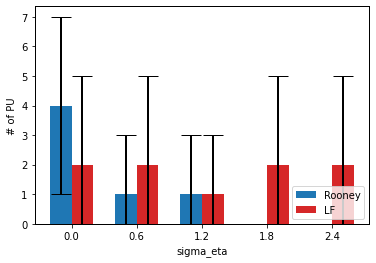

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<Figure size 432x288 with 0 Axes>

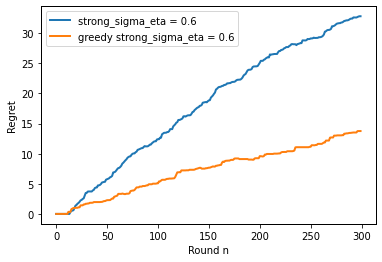

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<Figure size 432x288 with 0 Axes>

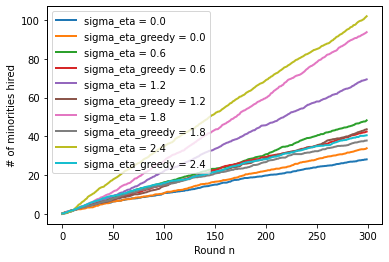

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<Figure size 432x288 with 0 Axes>

In [ ]:
# 2-stage dependence on eta
def experiment6():
    sigma_etas = np.sqrt(d) * np.array([0, 0.6, 1.2, 1.8, 2.4]) 
    pu_count = np.zeros(len(sigma_etas))
    pu_count_greedy = np.zeros(len(sigma_etas))
    all_regret = np.zeros((R, N, len(sigma_etas)))
    all_strong_regret = np.zeros((R, N, len(sigma_etas)))
    all_regret_greedy = np.zeros((R, N, len(sigma_etas)))
    all_strong_regret_greedy = np.zeros((R, N, len(sigma_etas)))
    all_draw2 = np.zeros((R, N,len(sigma_etas)))
    all_draw2_greedy = np.zeros((R, N,len(sigma_etas)))
    k_list = (10, 2) 
    for i,sigma_eta in enumerate(sigma_etas):
        sims = [Simulation(Kg = k_list, N0 = np.sum(k_list)*1, sigma_eta = sigma_eta, policy = "rooney") for r in range(R)] 
        sims_greedy = [Simulation(Kg = k_list, N0 = np.sum(k_list)*1, sigma_eta = sigma_eta, policy = "rooney_greedy") for r in range(R)]
        sims = Parallel(n_jobs=-1)( [delayed(run_sim)(sims[r]) for r in range(R)] ) #parallel computation
        sims_greedy = Parallel(n_jobs=-1)( [delayed(run_sim)(sims_greedy[r]) for r in range(R)] ) #parallel computation
        print(f"sigma_eta = {sigma_eta}")
        for r in range(R):
#            sims[r].run()
            if sims[r].is_perpetunderest():
                print(f"(rooney) PU occurred with i={i}, r={r}")
                pu_count[i] += 1
#            sims_greedy[r].run()
            if sims_greedy[r].is_perpetunderest():
                print(f"(greedy) PU occurred with i={i}, r={r}")
                pu_count_greedy[i] += 1
            all_regret[r,:,i] = sims[r].regret_seq
            all_strong_regret[r,:,i] = sims[r].strong_regret_seq
            all_regret_greedy[r,:,i] = sims_greedy[r].regret_seq
            #print(f"seq = {sims_greedy[r].strong_regret_seq}")
            all_strong_regret_greedy[r,:,i] = sims_greedy[r].strong_regret_seq
            all_draw2[r,:,i] = sims[r].draws_seq[:,1]
            all_draw2_greedy[r,:,i] = sims_greedy[r].draws_seq[:,1]
    print(f"pu_count = {pu_count}")

    labels = [sigma_eta for sigma_eta in sigma_etas]
    fig = plt.figure(figsize=Figsize)
    confs = [stats.binom.interval(0.95, n=R, p=min(max(0.0001,c/R),0.9999)) for i,c in enumerate(pu_count)]
    print(f"confs = {confs}")
    pu_count_intervals = ([pu_count[i]-conf[0] for i,conf in enumerate(confs)],  [conf[1]-pu_count[i] for i,conf in enumerate(confs)])
    w = 1 #plot bar width
    plt.bar(np.array(range(len(sigma_etas)))-w/6, pu_count, width=w/3, yerr = pu_count_intervals, align="center", capsize = Capsize, color = "tab:blue", label="Rooney")
    confs_greedy = [stats.binom.interval(0.95, n=R, p=min(max(0.0001,c/R),0.9999)) for i,c in enumerate(pu_count_greedy)]
    pu_count_intervals_greedy = ([pu_count_greedy[i]-conf[0] for i,conf in enumerate(confs_greedy)],  [conf[1]-pu_count_greedy[i] for i,conf in enumerate(confs_greedy)])
    plt.bar(np.array(range(len(sigma_etas)))+w/6, pu_count_greedy, width=w/3, yerr = pu_count_intervals_greedy, align="center", capsize = Capsize, color = "tab:red", label="LF")
    plt.xticks(ticks = np.array(range(len(sigma_etas))), labels = labels)
    plt.ylabel("# of PU")
    plt.xlabel("sigma_eta")
    plt.legend(loc='lower right')
    my_show()
    if save_img:
        fig.savefig('rooney_pu.pdf', dpi=fig.dpi)
        colab_save('rooney_pu.pdf')
    plt.clf()

    fig = plt.figure(figsize=Figsize)
    #plt.plot(range(N), avg_draw2, label = "LF")
    #plt.bar(range(len(sigma_etas)), avg_regret, tick_label=labels, align="center")
    avg_regret = np.mean(all_regret, axis=0)
    avg_regret_greedy = np.mean(all_regret_greedy, axis=0)
    avg_strong_regret = np.mean(all_strong_regret, axis=0)
    avg_strong_regret_greedy = np.mean(all_strong_regret_greedy, axis=0)
#    lower_quantile_regret = np.quantile(all_regret, 0.05, axis=0)
#    upper_quantile_regret = np.quantile(all_regret, 0.95, axis=0)
    for i,sigma_eta in enumerate(sigma_etas):
        if i==1:
            #plt.plot(range(N), avg_regret[:,i], label = "sigma_eta = "+str(sigma_eta))
            plt.plot(range(N), avg_strong_regret[:,i], label = "strong_sigma_eta = "+str(sigma_eta))
            plt.plot(range(N), avg_strong_regret_greedy[:,i], label = "greedy strong_sigma_eta = "+str(sigma_eta))
            #plt.plot(range(N), avg_regret_greedy[:,i], label = "greedy sigma_eta = "+str(sigma_eta))
    plt.ylabel("Regret")
#    plt.xlabel("sigma_eta")
    plt.xlabel("Round n")
    plt.legend()
    my_show()
    if save_img:
        fig.savefig('rooney_regret.pdf', dpi=fig.dpi)
        colab_save('rooney_regret.pdf')
    plt.clf()

    fig = plt.figure(figsize=Figsize)
    #plt.plot(range(N), avg_draw2, label = "LF")
    avg_draw2 = np.mean(all_draw2, axis=0)
    avg_draw2_greedy = np.mean(all_draw2_greedy, axis=0)
    for i,sigma_eta in enumerate(sigma_etas):
        plt.plot(range(N), avg_draw2[:,i], label = "sigma_eta = "+str(sigma_eta))
        plt.plot(range(N), avg_draw2_greedy[:,i], label = "sigma_eta_greedy = "+str(sigma_eta))
    plt.ylabel("# of minorities hired")
    plt.xlabel("Round n")
    plt.legend()
    my_show()
    if save_img:
        fig.savefig('rooney_draw2.pdf', dpi=fig.dpi)
        colab_save('rooney_draw2.pdf')
    plt.clf()

experiment6()

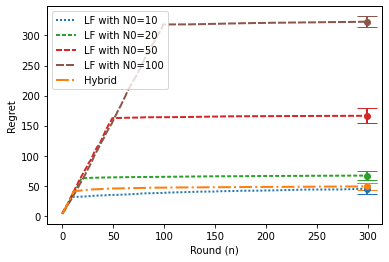

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

pu_count_all = [0, 1.0, 0.0, 0.0, 0.0]
confs = [(0.0, 0.0), (0.0, 3.0), (0.0, 0.0), (0.0, 0.0), (0.0, 0.0)]
pu_count_intervals = ([0.0, 1.0, 0.0, 0.0, 0.0], [0.0, 2.0, 0.0, 0.0, 0.0])
pu_count_all = [0, 1.0, 0.0, 0.0, 0.0]
labels = ['Hybrid', 'N0=10', 'N0=20', 'N0=50', 'N0=100']
pu_count_intervals = ([0.0, 1.0, 0.0, 0.0, 0.0], [0.0, 2.0, 0.0, 0.0, 0.0])


<Figure size 432x288 with 0 Axes>

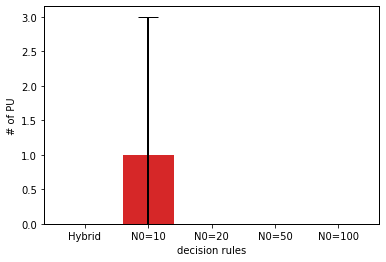

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

avg_subsidycs_all = [50.44974161155263, 30.336632799045372, 69.50873856488208, 180.18159033856378, 331.6404336139949]
subsidycs_intervals = ([20.286040388436906, 12.833196543841225, 30.698673622846755, 67.72691728319629, 55.02433474776063], [20.28604038843691, 12.833196543841229, 30.698673622846755, 67.72691728319629, 55.02433474776063])


No handles with labels found to put in legend.


<Figure size 432x288 with 0 Axes>

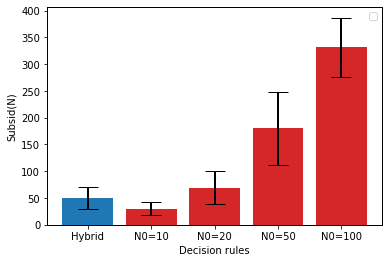

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<Figure size 432x288 with 0 Axes>

In [ ]:
# warm-start LF versus Hybrid
def experiment8():
    Kg = (10, 2)
    N0_list = [10, 20, 50, 100]
    pu_count_greedy = np.zeros(len(N0_list))
    pu_count_iucb = 0
    sims_greedy_list = [None for N0 in N0_list]
    for k,N0 in enumerate(N0_list):
        sims = [Simulation(Kg = Kg, N0 = N0, policy = "greedy", count_ws_regret = True) for r in range(R)]
        sims = Parallel(n_jobs=-1)( [delayed(run_sim)(sims[r]) for r in range(R)] ) #parallel computation
        for r in range(R):
            if sims[r].is_perpetunderest():
                pu_count_greedy[k] += 1
        sims_greedy_list[k] = sims
    sims_iucb = [Simulation(Kg = Kg, N0 = np.sum(Kg)*1, policy = "improved_ucb", count_ws_regret = True) for r in range(R)]
    sims_iucb = Parallel(n_jobs=-1)( [delayed(run_sim)(sims_iucb[r]) for r in range(R)] ) #parallel computation
    for r in range(R):
        #sims_iucb[r].run()
        if sims_iucb[r].is_perpetunderest():
            pu_count_iucb += 1

    all_regret_greedy = np.zeros( (R,N,len(N0_list)) )
    all_draw2_greedy = np.zeros( (R,N,len(N0_list)) )
    all_subsidy_greedy = np.zeros( (R,N,len(N0_list)) )
    all_subsidycs_greedy = np.zeros( (R,N,len(N0_list)) )
    all_regret_iucb = np.zeros( (R,N) )
    all_draw2_iucb = np.zeros( (R,N) )
    all_subsidy_iucb = np.zeros( (R,N) )
    all_subsidycs_iucb = np.zeros( (R,N) )
    for r in range(R):
        for k,N0 in enumerate(N0_list):
            all_regret_greedy[r,:,k] += sims_greedy_list[k][r].regret_seq
            all_draw2_greedy[r,:,k] += sims_greedy_list[k][r].draws_seq[:,1]
            all_subsidy_greedy[r,:,k] += sims_greedy_list[k][r].subsidy_seq
            all_subsidycs_greedy[r,:,k] += sims_greedy_list[k][r].subsidycs_seq
        all_regret_iucb[r] += sims_iucb[r].regret_seq
        all_draw2_iucb[r] += sims_iucb[r].draws_seq[:,1]
        all_subsidy_iucb[r] += sims_iucb[r].subsidy_seq
        all_subsidycs_iucb[r] += sims_iucb[r].subsidycs_seq

    fig = plt.figure(figsize=Figsize)
    avg_regret_greedy = np.mean(all_regret_greedy, axis=0) #N x k
    std_regret_greedy = np.std(all_regret_greedy, axis=0) #N x k
#    lower_quantile_regret_greedy = np.quantile(all_regret_greedy, 0.05, axis=0) #N x k
#    upper_quantile_regret_greedy = np.quantile(all_regret_greedy, 0.95, axis=0) #N x k
    colors = ['tab:blue', 'tab:green', 'tab:red', 'tab:brown']
    linestyles = [(0,(1,1)),(0,(2,1)),(0,(3,1)),(0,(4,1))]
    for k,N0 in enumerate(N0_list):
        plt.plot(range(N), avg_regret_greedy[:,k], label = f"LF with N0={N0}", color = colors[k], linestyle = linestyles[k]) #, color = COLOR_GREEDY, linestyle = LINESTYLE_GREEDY)
        #plt.fill_between(range(N), lower_quantile_regret_ucb, upper_quantile_regret_ucb, alpha=Alpha, color = COLOR_UCB)
        plt.errorbar([N-1], avg_regret_greedy[-1,k], yerr=2*std_regret_greedy[-1,k]/np.sqrt(R), fmt='o', color = colors[k], linestyle = linestyles[k], capsize = Capsize) #2 sigma

    avg_regret_iucb = np.mean(all_regret_iucb, axis=0)
    std_regret_iucb = np.std(all_regret_iucb, axis=0)
#    lower_quantile_regret_iucb = np.quantile(all_regret_iucb, 0.05, axis=0)
#    upper_quantile_regret_iucb = np.quantile(all_regret_iucb, 0.95, axis=0)
    plt.plot(range(N), avg_regret_iucb, label = "Hybrid", color = COLOR_HYBRID, linestyle = LINESTYLE_HYBRID)
    plt.errorbar([N-1], avg_regret_iucb[-1], yerr=2*std_regret_iucb[-1]/np.sqrt(R), fmt='o', capsize = Capsize, color = COLOR_HYBRID) #2 sigma
#    plt.fill_between(range(N), lower_quantile_regret_iucb, upper_quantile_regret_iucb, alpha=Alpha, color = COLOR_HYBRID)
    plt.ylabel("Regret")
    plt.xlabel("Round (n)")
    plt.legend()
    my_show()
    if save_img:
        fig.savefig('ws_compare_regret.pdf', dpi=fig.dpi)
        colab_save('ws_compare_regret.pdf')
    plt.clf()

    pu_count_all = [pu_count_iucb] + list(pu_count_greedy)
    print(f"pu_count_all = {pu_count_all}")
    confs = [stats.binom.interval(0.95, n=R, p=min(max(0.0001,c/R),0.9999)) for i,c in enumerate(pu_count_all)]
    print(f"confs = {confs}")
    pu_count_intervals = ([pu_count_all[i]-conf[0] for i,conf in enumerate(confs)],  [conf[1]-pu_count_all[i] for i,conf in enumerate(confs)])
    print(f"pu_count_intervals = {pu_count_intervals}")
    colors = ["tab:blue"] + ["tab:red" for N0 in N0_list] 
    labels = ["Hybrid"] + [f"N0={N0}" for N0 in N0_list]
    print(f"pu_count_all = {pu_count_all}")
    print(f"labels = {labels}")
    print(f"pu_count_intervals = {pu_count_intervals}")
    fig = plt.figure(figsize=Figsize)
    plt.bar(range(len(pu_count_all)), pu_count_all, tick_label=labels, yerr = pu_count_intervals, align="center", capsize = Capsize, color = colors)
    plt.ylabel("# of PU")
    plt.xlabel("decision rules")
    #plt.legend()
    my_show()
    if save_img:
        fig.savefig('ws_compare_pu.pdf', dpi=fig.dpi)
        colab_save('ws_compare_pu.pdf')
    plt.clf()


    fig = plt.figure(figsize=Figsize)
    avg_subsidycs_greedy = np.mean(all_subsidycs_greedy, axis=0) #N x k
    avg_subsidycs_iucb = np.mean(all_subsidycs_iucb, axis=0)
    std_subsidycs_greedy = np.std(all_subsidycs_greedy, axis=0) #N 
    std_subsidycs_iucb = np.std(all_subsidycs_iucb, axis=0)
    avg_subsidycs_all = [avg_subsidycs_iucb[-1]] + [avg_subsidycs_greedy[-1,k] for k,N0 in enumerate(N0_list)] 
    std_subsidycs_all = [std_subsidycs_iucb[-1]] + [std_subsidycs_greedy[-1,k] for k,N0 in enumerate(N0_list)] 
    confs = [stats.norm.interval(0.95, loc=c, scale=std_subsidycs_all[i]) for i,c in enumerate(avg_subsidycs_all)]
    subsidycs_intervals = ([avg_subsidycs_all[i]-conf[0] for i,conf in enumerate(confs)],  [conf[1]-avg_subsidycs_all[i] for i,conf in enumerate(confs)])
#    labels = ["Hybrid"] + [f"N0={N0}" for N0 in N0_list]
    print(f"avg_subsidycs_all = {avg_subsidycs_all}")
    print(f"subsidycs_intervals = {subsidycs_intervals}")
    plt.bar(range(len(avg_subsidycs_all)), avg_subsidycs_all, tick_label=labels, yerr = subsidycs_intervals, align="center", capsize = Capsize, color = colors)
    plt.ylabel("Subsid(N)")
    plt.xlabel("Decision rules")

    plt.legend()
    my_show()
    if save_img:
        fig.savefig('ws_compare_subsidy.pdf', dpi=fig.dpi)
        colab_save('ws_compare_subsidy.pdf')
    plt.clf()

experiment8()
#assert(False)

k_list = (2, 2)
PU occurred with i=0, r=1
k_list = (10, 2)
PU occurred with i=1, r=0
PU occurred with i=1, r=5
k_list = (30, 2)
PU occurred with i=2, r=0
PU occurred with i=2, r=3
PU occurred with i=2, r=6
k_list = (100, 2)
PU occurred with i=3, r=1
PU occurred with i=3, r=2
PU occurred with i=3, r=3
pu_count = [1. 2. 3. 3.]
confs = [(0.0, 3.0), (0.0, 5.0), (0.0, 6.0), (0.0, 6.0)]
pu_count_intervals = ([1.0, 2.0, 3.0, 3.0], [2.0, 3.0, 3.0, 3.0])


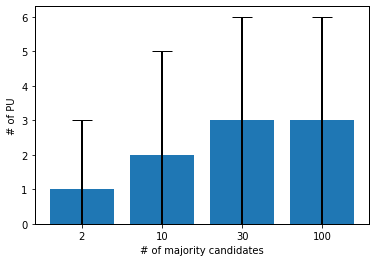

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<Figure size 432x288 with 0 Axes>

In [ ]:
# PU as a function of K1 (majority pop)
def experiment3():
    k_list_all = [(2,2),(10,2),(30,2),(100,2)]
    pu_count = np.zeros(len(k_list_all))
    for i,k_list in enumerate(k_list_all):
        sims = [Simulation(Kg = k_list, N0 = np.sum(k_list)*1, policy = "greedy") for r in range(R)]
        sims = Parallel(n_jobs=-1)( [delayed(run_sim)(sims[r]) for r in range(R)] ) #parallel computation
        print(f"k_list = {k_list}")
        for r in range(R):
            #sims[r].run()
            if sims[r].is_perpetunderest():
                print(f"PU occurred with i={i}, r={r}")
                pu_count[i] += 1
    print(f"pu_count = {pu_count}")
    confs = [stats.binom.interval(0.95, n=R, p=min(max(0.0001,c/R),0.9999)) for i,c in enumerate(pu_count)]
    print(f"confs = {confs}")
    pu_count_intervals = ([pu_count[i]-conf[0] for i,conf in enumerate(confs)],  [conf[1]-pu_count[i] for i,conf in enumerate(confs)])
    print(f"pu_count_intervals = {pu_count_intervals}")
    labels = [k_list[0] for k_list in k_list_all]
    fig = plt.figure(figsize=Figsize)
    plt.bar(range(len(k_list_all)), pu_count, tick_label=labels, yerr = pu_count_intervals, align="center", capsize = Capsize)
    plt.ylabel("# of PU")
    plt.xlabel("# of majority candidates")
    #plt.legend()
    my_show()
    if save_img:
        fig.savefig('groupsize_pu.pdf', dpi=fig.dpi)
        colab_save('groupsize_pu.pdf')
    plt.clf()

experiment3()

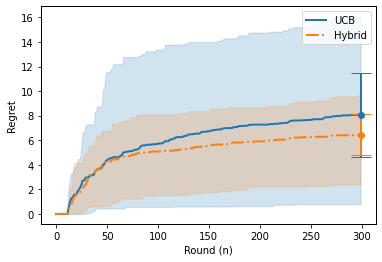

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<Figure size 432x288 with 0 Axes>

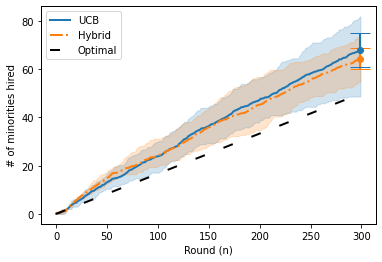

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<Figure size 432x288 with 0 Axes>

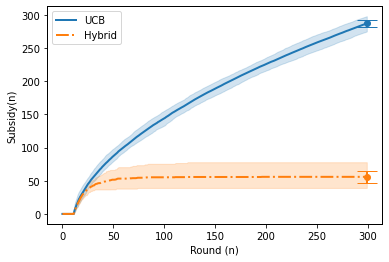

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<Figure size 432x288 with 0 Axes>

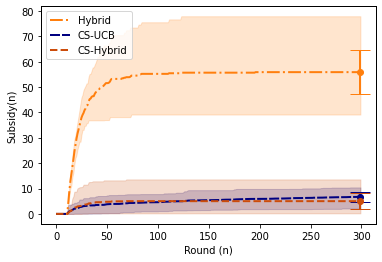

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<Figure size 432x288 with 0 Axes>

In [ ]:
# UCB versus Hybrid
def experiment2d():
    Kg = (10, 2)
    sims_ucb = [Simulation(Kg = Kg, N0 = np.sum(Kg)*1, policy = "ucb") for r in range(R)]
    sims_iucb = [Simulation(Kg = Kg, N0 = np.sum(Kg)*1, policy = "improved_ucb") for r in range(R)]
    sims_ucb = Parallel(n_jobs=-1)( [delayed(run_sim)(sims_ucb[r]) for r in range(R)] ) #parallel computation
    sims_iucb = Parallel(n_jobs=-1)( [delayed(run_sim)(sims_iucb[r]) for r in range(R)] ) #parallel computation

    all_regret_ucb = np.zeros( (R,N) )
    all_draw2_ucb = np.zeros( (R,N) )
    all_subsidy_ucb = np.zeros( (R,N) )
    all_subsidycs_ucb = np.zeros( (R,N) )
    all_regret_iucb = np.zeros( (R,N) )
    all_draw2_iucb = np.zeros( (R,N) )
    all_subsidy_iucb = np.zeros( (R,N) )
    all_subsidycs_iucb = np.zeros( (R,N) )
    for r in range(R):
        all_regret_ucb[r] += sims_ucb[r].regret_seq
        all_draw2_ucb[r] += sims_ucb[r].draws_seq[:,1]
        all_subsidy_ucb[r] += sims_ucb[r].subsidy_seq
        all_subsidycs_ucb[r] += sims_ucb[r].subsidycs_seq
        all_regret_iucb[r] += sims_iucb[r].regret_seq
        all_draw2_iucb[r] += sims_iucb[r].draws_seq[:,1]
        all_subsidy_iucb[r] += sims_iucb[r].subsidy_seq
        all_subsidycs_iucb[r] += sims_iucb[r].subsidycs_seq

    fig = plt.figure(figsize=Figsize)
    avg_regret_ucb = np.mean(all_regret_ucb, axis=0)
    std_regret_ucb = np.std(all_regret_ucb, axis=0)
    lower_quantile_regret_ucb = np.quantile(all_regret_ucb, 0.05, axis=0)
    upper_quantile_regret_ucb = np.quantile(all_regret_ucb, 0.95, axis=0)
    plt.plot(range(N), avg_regret_ucb, label = "UCB", color = COLOR_UCB, linestyle = LINESTYLE_UCB)
    plt.errorbar([N-1], avg_regret_ucb[-1], yerr=2*std_regret_ucb[-1]/np.sqrt(R), fmt='o', capsize = Capsize, color = COLOR_UCB) #2 sigma
    plt.fill_between(range(N), lower_quantile_regret_ucb, upper_quantile_regret_ucb, alpha=Alpha, color = COLOR_UCB)

    avg_regret_iucb = np.mean(all_regret_iucb, axis=0)
    std_regret_iucb = np.std(all_regret_iucb, axis=0)
    lower_quantile_regret_iucb = np.quantile(all_regret_iucb, 0.05, axis=0)
    upper_quantile_regret_iucb = np.quantile(all_regret_iucb, 0.95, axis=0)
    plt.plot(range(N), avg_regret_iucb, label = "Hybrid", color = COLOR_HYBRID, linestyle = LINESTYLE_HYBRID)
    plt.errorbar([N-1], avg_regret_iucb[-1], yerr=2*std_regret_iucb[-1]/np.sqrt(R), fmt='o', capsize = Capsize, color = COLOR_HYBRID) #2 sigma
    plt.fill_between(range(N), lower_quantile_regret_iucb, upper_quantile_regret_iucb, alpha=Alpha, color = COLOR_HYBRID)
    plt.ylabel("Regret")
    plt.xlabel("Round (n)")
    plt.legend()
    my_show()
    if save_img:
        fig.savefig('iucb_regret.pdf', dpi=fig.dpi)
        colab_save('iucb_regret.pdf')
    plt.clf()

    fig = plt.figure(figsize=Figsize)
    avg_draw2_ucb = np.mean(all_draw2_ucb, axis=0)
    std_draw2_ucb = np.std(all_draw2_ucb, axis=0)
    lower_quantile_draw2_ucb = np.quantile(all_draw2_ucb, 0.05, axis=0)
    upper_quantile_draw2_ucb = np.quantile(all_draw2_ucb, 0.95, axis=0)
    plt.plot(range(N), avg_draw2_ucb, label = "UCB", color = COLOR_UCB, linestyle = LINESTYLE_UCB)
    plt.errorbar([N-1], avg_draw2_ucb[-1], yerr=2*std_draw2_ucb[-1]/np.sqrt(R), fmt='o', capsize = Capsize, color = COLOR_UCB) #2 sigma
    plt.fill_between(range(N), lower_quantile_draw2_ucb, upper_quantile_draw2_ucb, alpha=Alpha, color = COLOR_UCB)

    avg_draw2_iucb = np.mean(all_draw2_iucb, axis=0)
    std_draw2_iucb = np.std(all_draw2_iucb, axis=0)
    lower_quantile_draw2_iucb = np.quantile(all_draw2_iucb, 0.05, axis=0)
    upper_quantile_draw2_iucb = np.quantile(all_draw2_iucb, 0.95, axis=0)
    plt.plot(range(N), avg_draw2_iucb, label = "Hybrid", color = COLOR_HYBRID, linestyle = LINESTYLE_HYBRID)
    plt.errorbar([N-1], avg_draw2_iucb[-1], yerr=2*std_draw2_iucb[-1]/np.sqrt(R), fmt='o', capsize = Capsize, color = COLOR_HYBRID) #2 sigma
    plt.fill_between(range(N), lower_quantile_draw2_iucb, upper_quantile_draw2_iucb, alpha=Alpha, color = COLOR_HYBRID)
    plt.plot(range(N), [i*Kg[1]/np.sum(Kg) for i in range(N)], label = "Optimal", color = "black", linestyle=linestyle_tuple["loosely dashed"])

    plt.ylabel("# of minorities hired")
    plt.xlabel("Round (n)")
    plt.legend()
    my_show()
    if save_img:
        fig.savefig('iucb_draw2.pdf', dpi=fig.dpi)
        colab_save('iucb_draw2.pdf')
    plt.clf()

    fig = plt.figure(figsize=Figsize)
    avg_subsidy_ucb = np.mean(all_subsidy_ucb, axis=0)
    std_subsidy_ucb = np.std(all_subsidy_ucb, axis=0)
    lower_quantile_subsidy_ucb = np.quantile(all_subsidy_ucb, 0.05, axis=0)
    upper_quantile_subsidy_ucb = np.quantile(all_subsidy_ucb, 0.95, axis=0)
    plt.plot(range(N), avg_subsidy_ucb, label = "UCB", color=COLOR_UCB, linestyle = LINESTYLE_UCB)
    plt.errorbar([N-1], avg_subsidy_ucb[-1], yerr=2*std_subsidy_ucb[-1]/np.sqrt(R), fmt='o', capsize = Capsize, color = COLOR_UCB) #2 sigma
    plt.fill_between(range(N), lower_quantile_subsidy_ucb, upper_quantile_subsidy_ucb, alpha=Alpha, color = COLOR_UCB)

    avg_subsidy_iucb = np.mean(all_subsidy_iucb, axis=0)
    std_subsidy_iucb = np.std(all_subsidy_iucb, axis=0)
    lower_quantile_subsidy_iucb = np.quantile(all_subsidy_iucb, 0.05, axis=0)
    upper_quantile_subsidy_iucb = np.quantile(all_subsidy_iucb, 0.95, axis=0)
    plt.plot(range(N), avg_subsidy_iucb, label = "Hybrid", color = COLOR_HYBRID, linestyle = LINESTYLE_HYBRID)
    plt.errorbar([N-1], avg_subsidy_iucb[-1], yerr=2*std_subsidy_iucb[-1]/np.sqrt(R), fmt='o', capsize = Capsize, color = COLOR_HYBRID) #2 sigma
    plt.fill_between(range(N), lower_quantile_subsidy_iucb, upper_quantile_subsidy_iucb, alpha=Alpha, color = COLOR_HYBRID)

    plt.ylabel("Subsidy(n)")
    plt.xlabel("Round (n)")
    plt.legend()
    my_show()
    if save_img:
        fig.savefig('iucb_subsidy.pdf', dpi=fig.dpi)
        colab_save('iucb_subsidy.pdf')
    plt.clf()

    fig = plt.figure(figsize=Figsize)
    avg_subsidy_iucb = np.mean(all_subsidy_iucb, axis=0)
    std_subsidy_iucb = np.std(all_subsidy_iucb, axis=0)
    lower_quantile_subsidy_iucb = np.quantile(all_subsidy_iucb, 0.05, axis=0)
    upper_quantile_subsidy_iucb = np.quantile(all_subsidy_iucb, 0.95, axis=0)
    plt.plot(range(N), avg_subsidy_iucb, label = "Hybrid", color = COLOR_HYBRID, linestyle = LINESTYLE_HYBRID)
    plt.errorbar([N-1], avg_subsidy_iucb[-1], yerr=2*std_subsidy_iucb[-1]/np.sqrt(R), fmt='o', capsize = Capsize, color = COLOR_HYBRID) #2 sigma
    plt.fill_between(range(N), lower_quantile_subsidy_iucb, upper_quantile_subsidy_iucb, alpha=Alpha, color = COLOR_HYBRID)

    avg_subsidycs_ucb = np.mean(all_subsidycs_ucb, axis=0)
    std_subsidycs_ucb = np.std(all_subsidycs_ucb, axis=0)
    lower_quantile_subsidycs_ucb = np.quantile(all_subsidycs_ucb, 0.05, axis=0)
    upper_quantile_subsidycs_ucb = np.quantile(all_subsidycs_ucb, 0.95, axis=0)
    plt.plot(range(N), avg_subsidycs_ucb, label = "CS-UCB", color = COLOR_CS_UCB, linestyle = LINESTYLE_CS_UCB)
    plt.errorbar([N-1], avg_subsidycs_ucb[-1], yerr=2*std_subsidycs_ucb[-1]/np.sqrt(R), fmt='o', capsize = Capsize, color = COLOR_CS_UCB) #2 sigma
    plt.fill_between(range(N), lower_quantile_subsidycs_ucb, upper_quantile_subsidycs_ucb, alpha=Alpha, color = COLOR_CS_UCB)

    avg_subsidycs_iucb = np.mean(all_subsidycs_iucb, axis=0)
    std_subsidycs_iucb = np.std(all_subsidycs_iucb, axis=0)
    lower_quantile_subsidycs_iucb = np.quantile(all_subsidycs_iucb, 0.05, axis=0)
    upper_quantile_subsidycs_iucb = np.quantile(all_subsidycs_iucb, 0.95, axis=0)
    plt.plot(range(N), avg_subsidycs_iucb, label = "CS-Hybrid", color = COLOR_CS_HYBRID, linestyle = LINESTYLE_CS_HYBRID)
    plt.errorbar([N-1], avg_subsidycs_iucb[-1], yerr=2*std_subsidycs_iucb[-1]/np.sqrt(R), fmt='o', capsize = Capsize, color = COLOR_CS_HYBRID) #2 sigma
    plt.fill_between(range(N), lower_quantile_subsidycs_iucb, upper_quantile_subsidycs_iucb, alpha=Alpha, color = COLOR_CS_HYBRID)

    plt.ylabel("Subsidy(n)")
    plt.xlabel("Round (n)")
    plt.legend()
    my_show()
    if save_img:
        fig.savefig('iucb_subsidy_cs.pdf', dpi=fig.dpi)
        colab_save('iucb_subsidy_cs.pdf')
    plt.clf()

experiment2d()

confs = [(0.0, 5.0), (0.0, 3.0), (0.0, 0.0), (0.0, 0.0)]


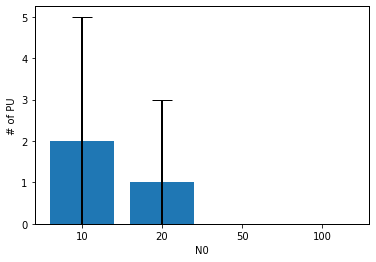

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<Figure size 432x288 with 0 Axes>

In [ ]:
# Warm-start size (not used)
def experiment4():
    Kg = (10, 2)
    N0_list = [10, 20, 50, 100]
    pu_count = np.zeros(len(N0_list))
    for k,N0 in enumerate(N0_list):
        sims = [Simulation(Kg = Kg, N0 = N0, policy = "greedy") for r in range(R)]
        sims = Parallel(n_jobs=-1)( [delayed(run_sim)(sims[r]) for r in range(R)] ) #parallel computation
        for r in range(R):
#            sims[r].run()
            if sims[r].is_perpetunderest():
                pu_count[k] += 1
    labels = [N0 for N0 in N0_list]
    fig = plt.figure(figsize=Figsize)
    confs = [stats.binom.interval(0.95, n=R, p=min(max(0.0001,c/R),0.9999)) for i,c in enumerate(pu_count)]
    print(f"confs = {confs}")
    pu_count_intervals = ([pu_count[i]-conf[0] for i,conf in enumerate(confs)],  [conf[1]-pu_count[i] for i,conf in enumerate(confs)])
    plt.bar(range(len(N0_list)), pu_count, yerr = pu_count_intervals, tick_label=labels, align="center", capsize = Capsize)
    plt.ylabel("# of PU")
    plt.xlabel("N0")
    #plt.legend()
    my_show()
    if save_img:
        fig.savefig('wssize_pu.pdf', dpi=fig.dpi)
        colab_save('wssize_pu.pdf')
    plt.clf()

experiment4()

k_list = (10, 2)
PU occurred with i=0, r=2
PU occurred with i=0, r=3
k_list = (10, 2)
k_list = (10, 2)
PU occurred with i=2, r=0
PU occurred with i=2, r=1
PU occurred with i=2, r=5
k_list = (10, 2)
PU occurred with i=3, r=1
PU occurred with i=3, r=2
PU occurred with i=3, r=5
PU occurred with i=3, r=7
k_list = (10, 2)
PU occurred with i=4, r=1
PU occurred with i=4, r=5
PU occurred with i=4, r=6
pu_count = [2. 0. 3. 4. 3.]
confs = [(0.0, 5.0), (0.0, 0.0), (0.0, 6.0), (1.0, 7.0), (0.0, 6.0)]


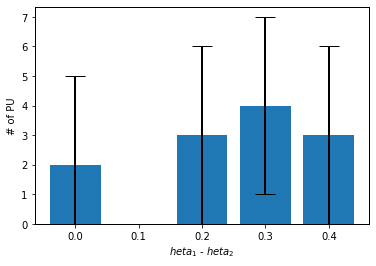

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<Figure size 432x288 with 0 Axes>

In [ ]:
# Not used (assymetric model)
def experiment5():
    theta_diffs = [0, 0.1, 0.2, 0.3, 0.4]
    pu_count = np.zeros(len(theta_diffs))
    for i,theta_diff in enumerate(theta_diffs):
        k_list = (10, 2)
        sims = [Simulation(Kg = k_list, N0 = np.sum(k_list)*1, theta_pars = [1,1-theta_diff], policy = "greedy") for r in range(R)]
        sims = Parallel(n_jobs=-1)( [delayed(run_sim)(sims[r]) for r in range(R)] ) #parallel computation
        print(f"k_list = {k_list}")
        for r in range(R):
#            sims[r].run()
            if sims[r].is_perpetunderest():
                print(f"PU occurred with i={i}, r={r}")
                pu_count[i] += 1
    print(f"pu_count = {pu_count}")
    labels = [theta_diff for theta_diff in theta_diffs]
    fig = plt.figure(figsize=Figsize)
    confs = [stats.binom.interval(0.95, n=R, p=min(max(0.0001,c/R),0.9999)) for i,c in enumerate(pu_count)]
    print(f"confs = {confs}")
    pu_count_intervals = ([pu_count[i]-conf[0] for i,conf in enumerate(confs)],  [conf[1]-pu_count[i] for i,conf in enumerate(confs)])
    plt.bar(range(len(theta_diffs)), pu_count, yerr = pu_count_intervals, tick_label=labels, align="center", capsize = Capsize)
    plt.ylabel("# of PU")
    plt.xlabel("$\theta_1$ - $\theta_2$")
    #plt.legend()
    my_show()
    if save_img:
        fig.savefig('thetadiff_pu.pdf', dpi=fig.dpi)
        colab_save('thetadiff_pu.pdf')
    plt.clf()

experiment5()

test sims_ucb[0].regret_seq.shape = (5000,)
sims_ucb[r].regret_seq.shape = (5000,)
sims_ucb[r].regret_seq.shape = (5000,)
sims_ucb[r].regret_seq.shape = (5000,)
sims_ucb[r].regret_seq.shape = (5000,)
sims_ucb[r].regret_seq.shape = (5000,)


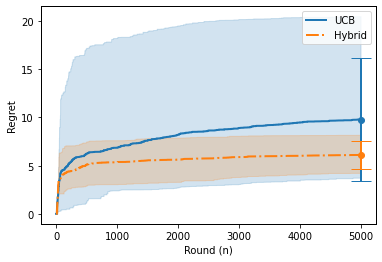

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<Figure size 432x288 with 0 Axes>

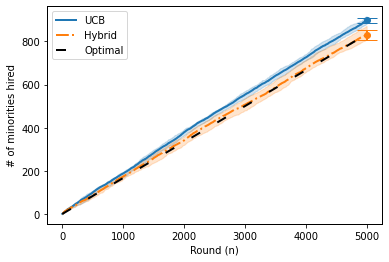

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<Figure size 432x288 with 0 Axes>

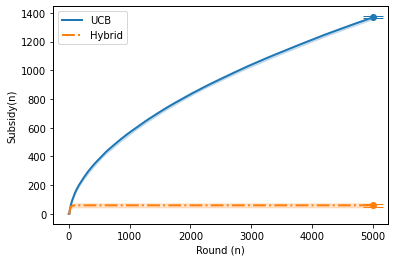

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<Figure size 432x288 with 0 Axes>

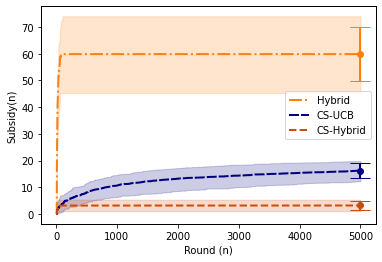

In [ ]:
# version of experiment 2 with N=10000
def experiment2dlong():
    global N, R
    Kg = (10, 2)
    if run_full or (not is_colab()): # outside colab
        N = 10000
        R = 50
    else:
        N = 5000
        R = 5

    sims_ucb = [Simulation(Kg = Kg, N0 = np.sum(Kg)*1, N=N, policy = "ucb") for r in range(R)]
    print(f"test sims_ucb[0].regret_seq.shape = {sims_ucb[0].regret_seq.shape}")
    sims_ucb = Parallel(n_jobs=-1)( [delayed(run_sim)(sims_ucb[r]) for r in range(R)] ) #parallel computation
    sims_iucb = [Simulation(Kg = Kg, N0 = np.sum(Kg)*1, N=N, policy = "improved_ucb") for r in range(R)]
    sims_iucb = Parallel(n_jobs=-1)( [delayed(run_sim)(sims_iucb[r]) for r in range(R)] ) #parallel computation
#    for r in range(R):
#        sims_ucb[r].run()
#        print(f"UCB Run {r}: Perpetually underestimated {sims_ucb[r].is_perpetunderest()}")
#    for r in range(R):
#        sims_iucb[r].run()
#        print(f"iUCB Run {r}: Perpetually underestimated {sims_ucb[r].is_perpetunderest()}")
    all_regret_ucb = np.zeros( (R,N) )
    all_draw2_ucb = np.zeros( (R,N) )
    all_subsidy_ucb = np.zeros( (R,N) )
    all_subsidycs_ucb = np.zeros( (R,N) )
    all_regret_iucb = np.zeros( (R,N) )
    all_draw2_iucb = np.zeros( (R,N) )
    all_subsidy_iucb = np.zeros( (R,N) )
    all_subsidycs_iucb = np.zeros( (R,N) )
    for r in range(R):
        print(f"sims_ucb[r].regret_seq.shape = {sims_ucb[r].regret_seq.shape}")
        all_regret_ucb[r] += sims_ucb[r].regret_seq
        all_draw2_ucb[r] += sims_ucb[r].draws_seq[:,1]
        all_subsidy_ucb[r] += sims_ucb[r].subsidy_seq
        all_subsidycs_ucb[r] += sims_ucb[r].subsidycs_seq
        all_regret_iucb[r] += sims_iucb[r].regret_seq
        all_draw2_iucb[r] += sims_iucb[r].draws_seq[:,1]
        all_subsidy_iucb[r] += sims_iucb[r].subsidy_seq
        all_subsidycs_iucb[r] += sims_iucb[r].subsidycs_seq

    fig = plt.figure(figsize=Figsize)
    avg_regret_ucb = np.mean(all_regret_ucb, axis=0)
    std_regret_ucb = np.std(all_regret_ucb, axis=0)
    lower_quantile_regret_ucb = np.quantile(all_regret_ucb, 0.05, axis=0)
    upper_quantile_regret_ucb = np.quantile(all_regret_ucb, 0.95, axis=0)
    plt.plot(range(N), avg_regret_ucb, label = "UCB", color = COLOR_UCB, linestyle = LINESTYLE_UCB)
    plt.errorbar([N-1], avg_regret_ucb[-1], yerr=2*std_regret_ucb[-1]/np.sqrt(R), fmt='o', capsize = Capsize, color = COLOR_UCB) #2 sigma
    plt.fill_between(range(N), lower_quantile_regret_ucb, upper_quantile_regret_ucb, alpha=Alpha, color = COLOR_UCB)

    avg_regret_iucb = np.mean(all_regret_iucb, axis=0)
    std_regret_iucb = np.std(all_regret_iucb, axis=0)
    lower_quantile_regret_iucb = np.quantile(all_regret_iucb, 0.05, axis=0)
    upper_quantile_regret_iucb = np.quantile(all_regret_iucb, 0.95, axis=0)
    plt.plot(range(N), avg_regret_iucb, label = "Hybrid", color = COLOR_HYBRID, linestyle = LINESTYLE_HYBRID)
    plt.errorbar([N-1], avg_regret_iucb[-1], yerr=2*std_regret_iucb[-1]/np.sqrt(R), fmt='o', capsize = Capsize, color = COLOR_HYBRID) #2 sigma
    plt.fill_between(range(N), lower_quantile_regret_iucb, upper_quantile_regret_iucb, alpha=Alpha, color = COLOR_HYBRID)
    plt.ylabel("Regret")
    plt.xlabel("Round (n)")
    plt.legend()
    my_show()
    if save_img:
        fig.savefig('iucb_regret_long.pdf', dpi=fig.dpi)
        colab_save('iucb_regret_long.pdf')
    plt.clf()

    fig = plt.figure(figsize=Figsize)
    avg_draw2_ucb = np.mean(all_draw2_ucb, axis=0)
    std_draw2_ucb = np.std(all_draw2_ucb, axis=0)
    lower_quantile_draw2_ucb = np.quantile(all_draw2_ucb, 0.05, axis=0)
    upper_quantile_draw2_ucb = np.quantile(all_draw2_ucb, 0.95, axis=0)
    plt.plot(range(N), avg_draw2_ucb, label = "UCB", color = COLOR_UCB, linestyle = LINESTYLE_UCB)
    plt.errorbar([N-1], avg_draw2_ucb[-1], yerr=2*std_draw2_ucb[-1]/np.sqrt(R), fmt='o', capsize = Capsize, color = COLOR_UCB) #2 sigma
    plt.fill_between(range(N), lower_quantile_draw2_ucb, upper_quantile_draw2_ucb, alpha=Alpha, color = COLOR_UCB)

    avg_draw2_iucb = np.mean(all_draw2_iucb, axis=0)
    std_draw2_iucb = np.std(all_draw2_iucb, axis=0)
    lower_quantile_draw2_iucb = np.quantile(all_draw2_iucb, 0.05, axis=0)
    upper_quantile_draw2_iucb = np.quantile(all_draw2_iucb, 0.95, axis=0)
    plt.plot(range(N), avg_draw2_iucb, label = "Hybrid", color = COLOR_HYBRID, linestyle = LINESTYLE_HYBRID)
    plt.errorbar([N-1], avg_draw2_iucb[-1], yerr=2*std_draw2_iucb[-1]/np.sqrt(R), fmt='o', capsize = Capsize, color = COLOR_HYBRID) #2 sigma
    plt.fill_between(range(N), lower_quantile_draw2_iucb, upper_quantile_draw2_iucb, alpha=Alpha, color = COLOR_HYBRID)
    plt.plot(range(N), [i*Kg[1]/np.sum(Kg) for i in range(N)], label = "Optimal", color = "black", linestyle=linestyle_tuple["loosely dashed"])

    plt.ylabel("# of minorities hired")
    plt.xlabel("Round (n)")
    plt.legend()
    my_show()
    if save_img:
        fig.savefig('iucb_draw2_long.pdf', dpi=fig.dpi)
        colab_save('iucb_draw2_long.pdf')
    plt.clf()

    fig = plt.figure(figsize=Figsize)
    avg_subsidy_ucb = np.mean(all_subsidy_ucb, axis=0)
    std_subsidy_ucb = np.std(all_subsidy_ucb, axis=0)
    lower_quantile_subsidy_ucb = np.quantile(all_subsidy_ucb, 0.05, axis=0)
    upper_quantile_subsidy_ucb = np.quantile(all_subsidy_ucb, 0.95, axis=0)
    plt.plot(range(N), avg_subsidy_ucb, label = "UCB", color=COLOR_UCB, linestyle = LINESTYLE_UCB)
    plt.errorbar([N-1], avg_subsidy_ucb[-1], yerr=2*std_subsidy_ucb[-1]/np.sqrt(R), fmt='o', capsize = Capsize, color = COLOR_UCB) #2 sigma
    plt.fill_between(range(N), lower_quantile_subsidy_ucb, upper_quantile_subsidy_ucb, alpha=Alpha, color = COLOR_UCB)

    avg_subsidy_iucb = np.mean(all_subsidy_iucb, axis=0)
    std_subsidy_iucb = np.std(all_subsidy_iucb, axis=0)
    lower_quantile_subsidy_iucb = np.quantile(all_subsidy_iucb, 0.05, axis=0)
    upper_quantile_subsidy_iucb = np.quantile(all_subsidy_iucb, 0.95, axis=0)
    plt.plot(range(N), avg_subsidy_iucb, label = "Hybrid", color = COLOR_HYBRID, linestyle = LINESTYLE_HYBRID)
    plt.errorbar([N-1], avg_subsidy_iucb[-1], yerr=2*std_subsidy_iucb[-1]/np.sqrt(R), fmt='o', capsize = Capsize, color = COLOR_HYBRID) #2 sigma
    plt.fill_between(range(N), lower_quantile_subsidy_iucb, upper_quantile_subsidy_iucb, alpha=Alpha, color = COLOR_HYBRID)

    plt.ylabel("Subsidy(n)")
    plt.xlabel("Round (n)")
    plt.legend()
    my_show()
    if save_img:
        fig.savefig('iucb_subsidy_long.pdf', dpi=fig.dpi)
        colab_save('iucb_subsidy_long.pdf')
    plt.clf()

    fig = plt.figure(figsize=Figsize)
    avg_subsidy_iucb = np.mean(all_subsidy_iucb, axis=0)
    std_subsidy_iucb = np.std(all_subsidy_iucb, axis=0)
    lower_quantile_subsidy_iucb = np.quantile(all_subsidy_iucb, 0.05, axis=0)
    upper_quantile_subsidy_iucb = np.quantile(all_subsidy_iucb, 0.95, axis=0)
    plt.plot(range(N), avg_subsidy_iucb, label = "Hybrid", color = COLOR_HYBRID, linestyle = LINESTYLE_HYBRID)
    plt.errorbar([N-1], avg_subsidy_iucb[-1], yerr=2*std_subsidy_iucb[-1]/np.sqrt(R), fmt='o', capsize = Capsize, color = COLOR_HYBRID) #2 sigma
    plt.fill_between(range(N), lower_quantile_subsidy_iucb, upper_quantile_subsidy_iucb, alpha=Alpha, color = COLOR_HYBRID)

    avg_subsidycs_ucb = np.mean(all_subsidycs_ucb, axis=0)
    std_subsidycs_ucb = np.std(all_subsidycs_ucb, axis=0)
    lower_quantile_subsidycs_ucb = np.quantile(all_subsidycs_ucb, 0.05, axis=0)
    upper_quantile_subsidycs_ucb = np.quantile(all_subsidycs_ucb, 0.95, axis=0)
    plt.plot(range(N), avg_subsidycs_ucb, label = "CS-UCB", color = COLOR_CS_UCB, linestyle = LINESTYLE_CS_UCB)
    plt.errorbar([N-1], avg_subsidycs_ucb[-1], yerr=2*std_subsidycs_ucb[-1]/np.sqrt(R), fmt='o', capsize = Capsize, color = COLOR_CS_UCB) #2 sigma
    plt.fill_between(range(N), lower_quantile_subsidycs_ucb, upper_quantile_subsidycs_ucb, alpha=Alpha, color = COLOR_CS_UCB)

    avg_subsidycs_iucb = np.mean(all_subsidycs_iucb, axis=0)
    std_subsidycs_iucb = np.std(all_subsidycs_iucb, axis=0)
    lower_quantile_subsidycs_iucb = np.quantile(all_subsidycs_iucb, 0.05, axis=0)
    upper_quantile_subsidycs_iucb = np.quantile(all_subsidycs_iucb, 0.95, axis=0)
    plt.plot(range(N), avg_subsidycs_iucb, label = "CS-Hybrid", color = COLOR_CS_HYBRID, linestyle = LINESTYLE_CS_HYBRID)
    plt.errorbar([N-1], avg_subsidycs_iucb[-1], yerr=2*std_subsidycs_iucb[-1]/np.sqrt(R), fmt='o', capsize = Capsize, color = COLOR_CS_HYBRID) #2 sigma
    plt.fill_between(range(N), lower_quantile_subsidycs_iucb, upper_quantile_subsidycs_iucb, alpha=Alpha, color = COLOR_CS_HYBRID)

    plt.ylabel("Subsidy(n)")
    plt.xlabel("Round (n)")
    plt.legend()
    my_show()
    if save_img:
        fig.savefig('iucb_subsidy_cs_long.pdf', dpi=fig.dpi)
        colab_save('iucb_subsidy_cs_long.pdf')
    plt.clf()


experiment2dlong()